# 2D Gaussian tomography

## Imports

In [1]:
#Imports

import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import string
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras import layers
from tensorflow.keras.utils import plot_model
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from skimage.metrics import structural_similarity as ssim
import matplotlib.cm as cm
from matplotlib.colors import Normalize
#import esmda_full
from scipy.optimize import minimize
from datetime import datetime

In [2]:
# input: (60000,28,28); output: (60000,28,28,1)
def reshape_for_CNN(coarse_train,coarse_test,dim):

  coarse_train=np.reshape(coarse_train, (len(coarse_train), dim[0], dim[1], 1))
  coarse_test=np.reshape(coarse_test, (len(coarse_test), dim[0], dim[1], 1))
  return coarse_train,coarse_test

In [3]:
# take in (60000,28,28) ; specify dim to upscale; coarsen, normalize;   output: either (x1*x2) or (x1, x2, 1)
def upscale_normalize_reshape(train_x,test_x,dim,cnn):
# dim=(n,n); 
# train_x.shape - (60000,28,28)

    train_x=train_x.astype('float32')
    test_x= test_x.astype('float32')

    #train_x=np.reshape(train_x, (len(train_x), int(train_x.shape[1]), int(train_x.shape[1]))) # if 
    #test_x=np.reshape(test_x, (len(test_x), int(test_x.shape[1]), int(test_x.shape[1])))

    # coarsen training data
    coarse_train=np.zeros((train_x.shape[0],dim[0],dim[1]))
    for i in range(train_x.shape[0]):
        coarse_train[i] = cv2.resize(train_x[i], dim, interpolation = cv2.INTER_AREA)
        
    #coarsen test data
    coarse_test=np.zeros((test_x.shape[0],dim[0],dim[1]))
    for i in range(test_x.shape[0]):
        coarse_test[i] = cv2.resize(test_x[i], dim, interpolation = cv2.INTER_AREA)

    # normalize
    coarse_train=coarse_train.astype('float32') / np.absolute(coarse_train).max()
    coarse_test=coarse_test.astype('float32') / np.absolute(coarse_test).max()
    
    if cnn==True:
        coarse_train,coarse_test=reshape_for_CNN(coarse_train,coarse_test,dim)
    else:
        coarse_train=np.reshape(coarse_train, (len(coarse_train), dim[0]*dim[1]))
        coarse_test=np.reshape(coarse_test, (len(coarse_test), dim[0]*dim[1]))
    return coarse_train, coarse_test

In [4]:
# divide by max value and convert values to 0,1
def normalize_discretize(x_train, x_test):
    
    x_train=x_train.astype('float32') / x_train.max()
    x_test=x_test.astype('float32') / x_test.max()
    x_train=np.where(x_train<0.5, 0, 1)
    x_test=np.where(x_test<0.5, 0, 1)
    return x_train, x_test

In [5]:
# convert to 0,1; input should be in range (0,1)
def discretize(x_train, x_test):
    
    x_train=np.where(x_train<0.5, 0, 1)
    x_test=np.where(x_test<0.5, 0, 1)
    return x_train, x_test

In [6]:
# take 2 images and plot: 1) top: original 2) bottom: reconstruction
def plot_reconstruction1(original,reconstruction,dim1,dim2):


  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # Display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(original[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.title('Original fine test')

      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(reconstruction[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.title('Reconstructed test')
  plt.colorbar()
  plt.show()

In [7]:
# plot loss of a custom model by accessing history attribute of model
def plot_loss(history):
    plt.figure(figsize=(10,10))
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['reg7x7_loss'])
    plt.plot(history.history['reg14x14_loss'])
    plt.plot(history.history['reg28x28_loss'])
    
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_reg7x7_loss'])
    plt.plot(history.history['val_reg14x14_loss'])
    plt.plot(history.history['val_reg28x28_loss'])
    
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_total','train7x7','train14x14','train28x28','val_total','val7x7','val14x14','val28x28'], loc='upper right')
    #plt.savefig('model1_leakyrelu.png', dpi=500)
    plt.show()

## Data Generation

In [8]:
gaussian_data = np.load(r'C:\Users\Mahammad\OneDrive\Desktop\USC_2021\Research\Data_assimilation\Multiscale_HM_ENKF\Multiscale_gradient_based\RSC_2023\Gaussian\gaussian_data_5000_16384.npy')
gaussian_data.shape

(5000, 16384)

In [9]:
# Split to train, test

x_train=gaussian_data[:4500]          # 450
print(x_train.shape)
x_test=gaussian_data[4500:]        # 50
print(x_test.shape)


x_train=np.reshape(x_train, (len(x_train),128, 128))
x_test=np.reshape(x_test, (len(x_test), 128, 128))
print(x_train.shape)
print(x_test.shape)

(4500, 16384)
(500, 16384)
(4500, 128, 128)
(500, 128, 128)


(4500, 64, 64)
(500, 64, 64)
4.84133
-5.66942


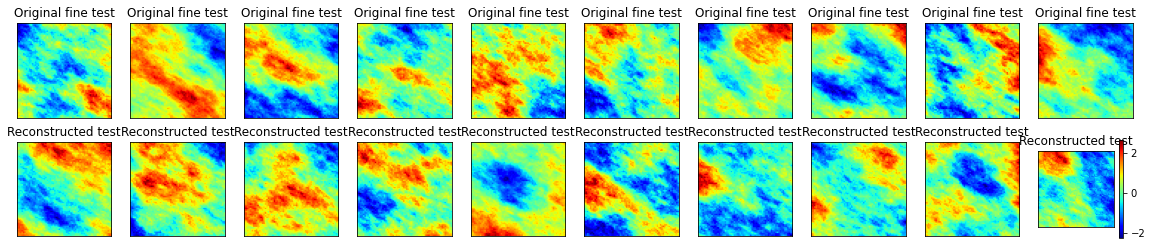

In [10]:
# Crop 64x64

x_train=x_train[:,32:96,32:96]
x_test=x_test[:,32:96,32:96]
print(x_train.shape)
print(x_test.shape)
print(x_train.max())
print(x_train.min())
plot_reconstruction1(x_train,x_test,64,64)

In [11]:
# Assign train data to 64x64

train64_64nd, test64_64nd=(x_train, x_test)
print(train64_64nd.shape)
print(np.histogram(train64_64nd))
print(train64_64nd.max())
print(train64_64nd.min())

(4500, 64, 64)
(array([    143,    2248,   85289, 1101297, 4889208, 7519845, 4048490,
        736990,   47729,     761], dtype=int64), array([-5.66942 , -4.618345, -3.56727 , -2.516195, -1.46512 , -0.414045,
        0.63703 ,  1.688105,  2.73918 ,  3.790255,  4.84133 ]))
4.84133
-5.66942


In [12]:
# upscale_reshape_normalize

train8_8dn, test8_8dn=upscale_normalize_reshape(train64_64nd,test64_64nd,(8,8),cnn=False)
train8_8cnndn, test8_8cnndn=upscale_normalize_reshape(train64_64nd,test64_64nd,(8,8),cnn=True)

train16_16dn, test16_16dn=upscale_normalize_reshape(train64_64nd,test64_64nd,(16,16),cnn=False)
train16_16cnndn, test16_16cnndn=upscale_normalize_reshape(train64_64nd,test64_64nd,(16,16),cnn=True)

train32_32dn, test32_32dn=upscale_normalize_reshape(train64_64nd,test64_64nd,(32,32),cnn=False)
train32_32cnndn, test32_32cnndn=upscale_normalize_reshape(train64_64nd,test64_64nd,(32,32),cnn=True)

train64_64dn, test64_64dn=upscale_normalize_reshape(train64_64nd,test64_64nd,(64,64),cnn=False)
train64_64cnndn, test64_64cnndn=upscale_normalize_reshape(train64_64nd,test64_64nd,(64,64),cnn=True)

#train28_28dn, test28_28dn=train28_28nd, test28_28nd
print(train8_8dn.shape)
print(train8_8cnndn.shape)
print(np.histogram(train8_8dn))
print(train16_16dn.shape)
print(np.histogram(train16_16dn))
print(train32_32dn.shape)
print(np.histogram(train32_32dn))
print(train64_64dn.shape)
print(np.histogram(train64_64dn))
print(train8_8dn.min())
print(train8_8dn.max())
print(train16_16dn.min())
print(train16_16dn.max())
print(train32_32dn.min())
print(train32_32dn.max())
print(train64_64dn.min())
print(train64_64dn.max())

(4500, 64)
(4500, 8, 8, 1)
(array([     6,     84,   2060,  18049,  67453, 106311,  71718,  19858,
         2330,    131], dtype=int64), array([-1.        , -0.8186204 , -0.63724077, -0.45586112, -0.2744815 ,
       -0.09310189,  0.08827773,  0.26965734,  0.451037  ,  0.6324166 ,
        0.8137962 ], dtype=float32))
(4500, 256)
(array([    14,    175,   5546,  61936, 269387, 448429, 289373,  70320,
         6573,    247], dtype=int64), array([-1.        , -0.81880665, -0.6376133 , -0.45641997, -0.27522665,
       -0.0940333 ,  0.08716004,  0.26835337,  0.44954672,  0.63074005,
        0.8119334 ], dtype=float32))
(4500, 1024)
(array([     46,     574,   20547,  253838, 1137248, 1845123, 1099580,
        232582,   18011,     451], dtype=int64), array([-1.        , -0.8170468 , -0.6340936 , -0.4511404 , -0.2681872 ,
       -0.08523399,  0.09771921,  0.28067243,  0.4636256 ,  0.64657885,
        0.829532  ], dtype=float32))
(4500, 4096)
(array([    143,    2248,   85289, 1101297, 4889208,

# Import trained models (import, predict, plot)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 8, 1)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 32)          320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 32)        4128      
_________________________________________________________________
x16 (Conv2DTranspose)        (None, 16, 16, 1)         289       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        320   

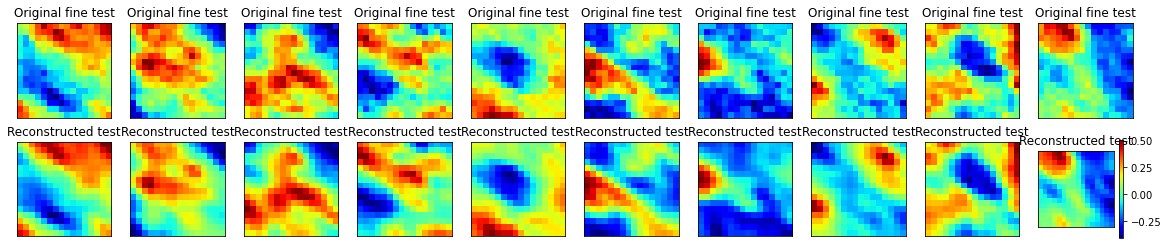

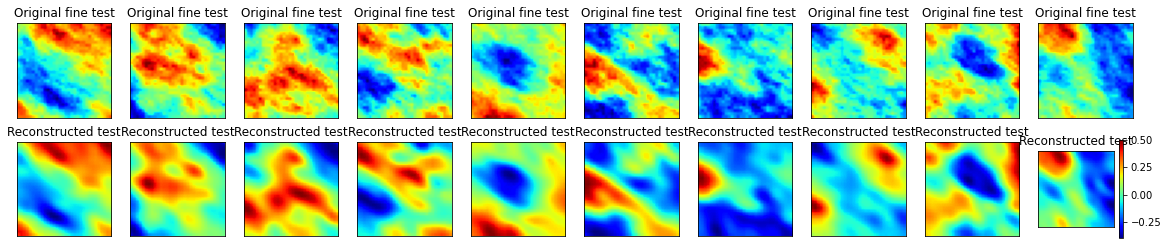

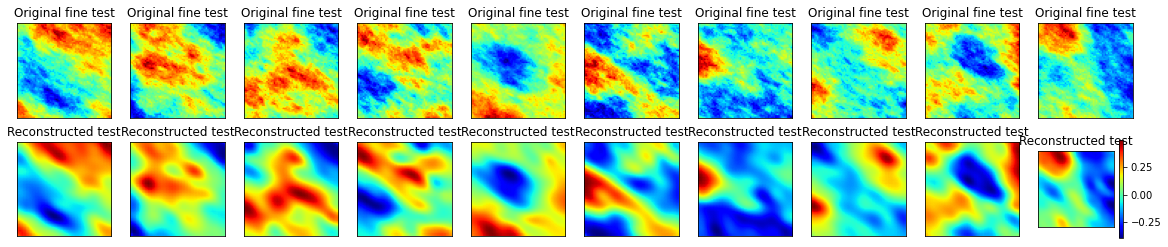

In [13]:
model_1 = keras.models.load_model('multiscale.h5')
model_1.summary()

pred16_16f5,pred32_32f5,pred64_64f5  = model_1.predict(test8_8cnndn)
print(pred16_16f5.shape)

#plot predictions from model
plot_reconstruction1(test16_16dn,pred16_16f5,16,16)
plot_reconstruction1(test32_32dn,pred32_32f5,32,32)
plot_reconstruction1(test64_64dn,pred64_64f5,64,64)

# G and flow data

In [14]:
# local
import scipy.io
G_global= scipy.io.loadmat('G32_32_2way.mat')
G_global =G_global['G32_32_2way']
print(G_global.shape)
print(type(G_global))


(2048, 1024)
<class 'numpy.ndarray'>


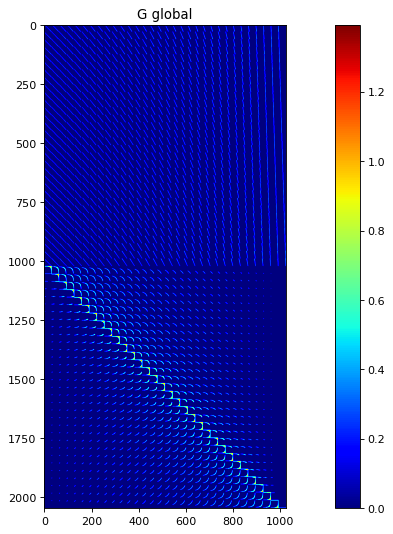

In [15]:
plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(G_global)
plt.jet()
plt.title('G global')
plt.colorbar()
plt.show()


In [16]:
for i in range(G_global.shape[0]):
    a=G_global[i,:]
    a=np.reshape(a,(32,32))
    a=a.T
    a=a.flatten()
    G_global[i,:]=a
print(G_global.shape)

(2048, 1024)


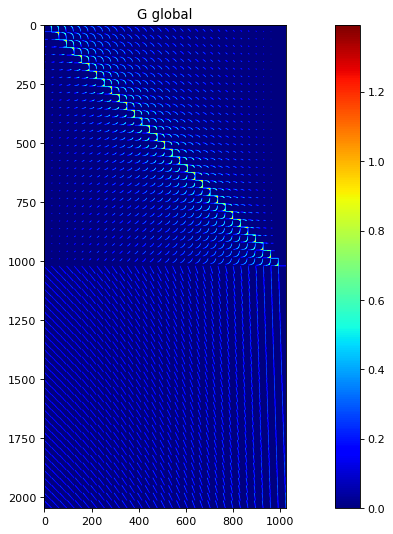

In [17]:
plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(G_global)
plt.jet()
plt.title('G global')
plt.colorbar()
plt.show()
G_global=G_global.T

## Gradient-based data assimilation

(4096,)
-0.6413801
0.467241
--------------
-0.9331514-16-0.7948146
-0.91515636-32--0.91515636
-0.8943294-64--0.8943294


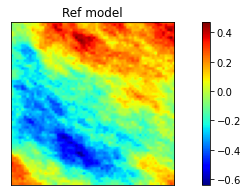

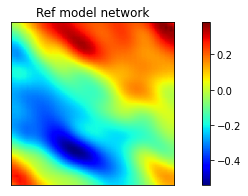

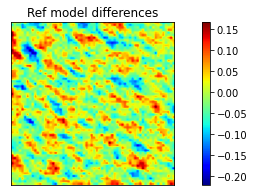

In [18]:
# Choose reference

ref=0

m_ref=np.squeeze(test64_64dn[ref:ref+1,:].T)
print(m_ref.shape)
print(m_ref.min())
print(m_ref.max())

# Plot reference

f = plt.figure(figsize=(10, 3))
plt.imshow(np.reshape(m_ref, [64, 64]),aspect='equal')
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.title("Ref model")

f = plt.figure(figsize=(10, 3))
plt.imshow(np.reshape(pred64_64f5[ref:ref+1,:], [64, 64]),aspect='equal')
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.title("Ref model network")

f = plt.figure(figsize=(10, 3))
plt.imshow((np.reshape(m_ref, [64, 64])-np.reshape(pred64_64f5[ref:ref+1,:], [64, 64])),aspect='equal')
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.title("Ref model differences")


print('--------------')
print(str(pred16_16f5.min())+'-16-'+str(pred16_16f5.max()))
print(str(pred32_32f5.min())+'-32-'+str(pred32_32f5.min()))
print(str(pred64_64f5.min())+'-64-'+str(pred64_64f5.min()))

In [19]:
# Generate flow data
m_ref2=m_ref.copy()
m_ref2=np.reshape(m_ref2,(64,64))
m_ref2=m_ref2[0:32,0:32].flatten()
m_ref2=np.squeeze(m_ref2)
print(m_ref2.shape)

d_obs_global = np.reshape(m_ref2, [1, m_ref2.shape[0]])@G_global
d_obs_global= np.squeeze(d_obs_global)



print(d_obs_global.shape) # (128,)
print(max(d_obs_global))
print(min(d_obs_global))



print(d_obs_global)

(1024,)
(2048,)
7.052306975818009
-8.75322338938713
[5.0188168  5.0212668  4.37709675 ... 2.98954295 2.99101792 2.90701149]


In [20]:
# Upscale reference images: 1) 64x64   2) 32x32  3)  16x16   4)  8x8

m_ref64x64=np.reshape(m_ref,(64,64))
m_ref64x64=m_ref64x64.astype('float32')

# 8x8
m_ref8x8=np.zeros((8,8))
m_ref8x8=cv2.resize(m_ref64x64,(8,8),interpolation = cv2.INTER_AREA)
#m_ref8x8=m_ref8x8/m_ref8x8.max()
print(m_ref8x8.shape)
print(m_ref8x8.max())
print(m_ref8x8.min())

# 10x10
m_ref16x16=np.zeros((10,10))
m_ref16x16=cv2.resize(m_ref64x64,(16,16),interpolation = cv2.INTER_AREA)
#m_ref16x16=m_ref16x16/m_ref16x16.max()
print(m_ref16x16.shape)
print(m_ref16x16.max())
print(m_ref16x16.min())

# 15x15
m_ref32x32=np.zeros((15,15))
m_ref32x32=cv2.resize(m_ref64x64,(32,32),interpolation = cv2.INTER_AREA)
#m_ref32x32=m_ref32x32/m_ref32x32.max()
print(m_ref32x32.shape)
print(m_ref32x32.max())
print(m_ref32x32.min())

(8, 8)
0.33390704
-0.47149298
(16, 16)
0.3840795
-0.5405237
(32, 32)
0.42860812
-0.5768349


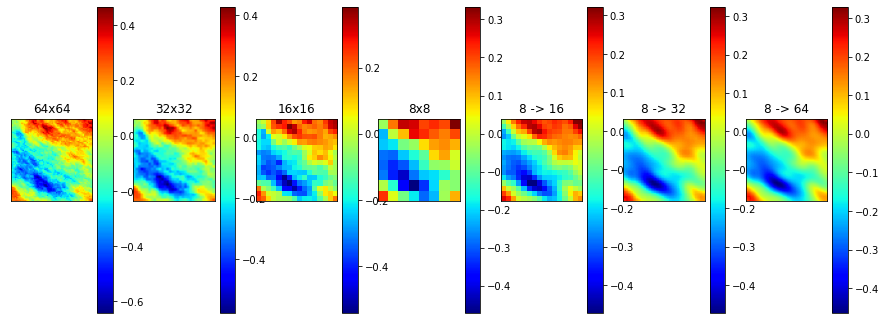

In [21]:
# Plot original and upscaled images

plt.figure(figsize=(15, 15))

# Display original
ax = plt.subplot(1, 7, 1)
plt.imshow(m_ref64x64.reshape(64, 64))
plt.jet()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('64x64')
#plt.clim(0, 1)
plt.colorbar()



# Display reconstruction
ax = plt.subplot(1, 7, 2)
plt.imshow(m_ref32x32.reshape(32, 32))
plt.jet()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('32x32')
#plt.clim(0, 1)
plt.colorbar()


# Display reconstruction
ax = plt.subplot(1, 7, 3)
plt.imshow(m_ref16x16.reshape(16, 16))
plt.jet()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('16x16')
#plt.clim(0, 1)
plt.colorbar()




# Display reconstruction
ax = plt.subplot(1, 7, 4)
plt.imshow(m_ref8x8.reshape(8, 8))
plt.jet()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('8x8')
#plt.clim(0, 1)
plt.colorbar()
#plt.show()

m_ref8to16=np.reshape(m_ref8x8,(1,8,8,1))
m_sol8_16  = model_1.predict(m_ref8to16)[0]

# Display reconstruction
ax = plt.subplot(1, 7, 5)
plt.imshow(m_sol8_16.reshape(16, 16))
plt.jet()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('8 -> 16')
#plt.clim(0, 1)
plt.colorbar()
#plt.show()

m_sol8_32  = model_1.predict(m_ref8to16)[1]

# Display reconstruction
ax = plt.subplot(1, 7, 6)
plt.imshow(m_sol8_32.reshape(32, 32))
plt.jet()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('8 -> 32')
#plt.clim(0, 1)
plt.colorbar()
#plt.show()

m_sol8_64  = model_1.predict(m_ref8to16)[2]

# Display reconstruction
ax = plt.subplot(1, 7, 7)
plt.imshow(m_sol8_64.reshape(64, 64))
plt.jet()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('8 -> 64')
#plt.clim(-0.2, 0.6)
plt.colorbar()
#plt.show()

In [103]:
def plot_reconstruction2(original,reconstruction,dim1,dim2):
  n = 3
  plt.figure(figsize=(13, 8))
  for i in range(n):
      # Display original
      #RMSE=sqrt(mean_squared_error(np.reshape(original[i],(dim1*dim2)), np.reshape(reconstruction[i],(dim1*dim2))))       
      ax = plt.subplot(2, n, i + 1)
      plt.subplots_adjust(left=0.01,
                    bottom=0.01,
                    right=0.99,
                    top=0.99,
                    wspace=0.08,
                    hspace=0.08)
      plt.imshow(original[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      #plt.title('Original fine test')
      plt.title('$m_{test}$',fontsize = 25)
      #plt.subplots_adjust(hspace = .02, wspace=.02)
      #plt.tight_layout() 
      plt.colorbar(shrink=0.85)
    
      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(reconstruction[i].reshape(dim1, dim2))
      plt.jet()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      #plt.title('Reconstructed test')
      plt.title('$m_{test}$',fontsize = 25)
      plt.colorbar(shrink=0.85)
  #plt.savefig('foo1.png',dpi=500)
  plt.show()

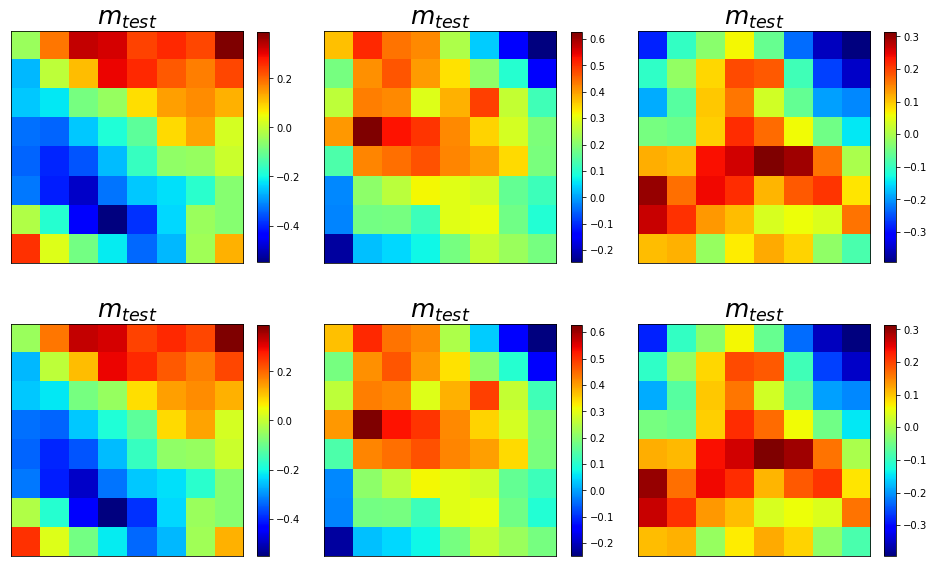

In [104]:
plot_reconstruction2(test8_8dn,test8_8dn,8,8)

## 8x8 Global

In [22]:
#callback to monitor optimization process
from IPython.display import clear_output

i8glob = 0
x8glo = []
losses8glo = []
logs8glo = []
grad8glo=[]
interm_sol8glo=[]
interm_sol64_8glo=[]
grad_v8glo=[]

def monitor8global(xk):
    
    global i8glob, x8glo, losses8glo, logs8glo, grad8glo, interm_sol8glo, interm_sol64_8glo, grad_v8glo
    
    fig = plt.figure(figsize=[15, 4])

    logs8glo.append(logs8glo)
    x8glo.append(i8glob)
    losses8glo.append(func8global(xk))
    i8glob += 1
    grad8glo.append(np.linalg.norm(dldm8global(xk)))
    
    clear_output(wait=True)
    
    plt.subplot(1, 3, 1)
    plt.plot(x8glo, losses8glo, label="loss", c = 'green')
    plt.ylabel("Loss function")
    plt.xlabel("Iter.")
    plt.title("Loss vs iter.")
    
    
    plt.subplot(1, 3, 2)
    plt.imshow(np.reshape(xk, [8, 8]), aspect='equal')
    plt.xticks([]), plt.yticks([])
    plt.title("Inv. model 8x8")
    #plt.clim(0, 1)
    plt.colorbar()
    

    interm_sol8glo.append(xk)
    xk=np.reshape(xk,(1,8,8,1))
    grad8glo.append(dldm8global(xk))
    xk = model_1.predict(xk)[2]
    interm_sol64_8glo.append(xk)
    
    
    plt.subplot(1, 3, 3)
    plt.imshow(np.reshape(xk, [64, 64]), aspect='equal')
    plt.xticks([]), plt.yticks([])
    plt.title("Inv. model 64x64")
    #plt.clim(0, 1)
    plt.colorbar()
    plt.show()
    

In [23]:
#objective function
def func8global(z8): #m5: 25-dimensional vector

    z8cnn=np.reshape(z8,(1,8,8,1))
    pred64_64f5_1  = model_1.predict(z8cnn)[2]    
    
    m64=np.reshape(pred64_64f5_1,(64,64))
    m64=m64[0:32,0:32]
    m64=m64.flatten()
    m64=np.squeeze(m64)
    
    obj=np.sqrt(np.mean(np.square(G_global.T@m64 - d_obs_global)))   #   f(z)     g(f(z))-
    
    return obj

In [24]:
#gradient of function

def dldm8global(z8):

    grad_L=np.zeros((64,1))
    z8=np.reshape(z8,(64,1))
    m01=np.zeros((64,1))
    m02=np.zeros((64,1))
    s8=np.reshape(np.arange(0,64),[8,8])
    for i in range(4):
        for j in range(4):
            dx=0.05
            dum1=np.zeros((64,1))
            dum1[s8[i][j],0]=dx
            m01=z8+dum1
            m02=z8-dum1
            L1=func8global(m01)
            L2=func8global(m02)
            grad_L[s8[i][j]]=(L1-L2)/(2*dx)
    grad_L=np.squeeze(grad_L)
    
    #print(grad_L)
    return grad_L

In [25]:
from scipy.optimize import Bounds
bounds8 =()
mm=[-1,1]
for i in range(64):
    bounds8=bounds8+(mm,)
print(bounds8)
len(bounds8)

([-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1])


64

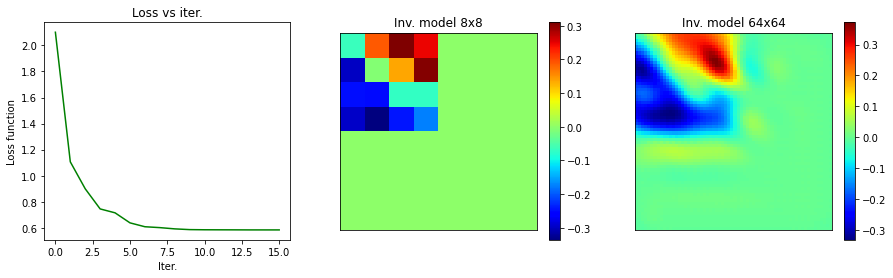

(64, 1)


In [26]:
# optimization; add time

#initial guess (sensitive!)
m08glo = np.zeros([64, 1])
#m08glo=np.reshape(m0_ens8x8,[64,1])
print(m08glo.shape)


#minimize the objective function
res8glob = minimize(func8global, m08glo, method='L-BFGS-B', jac=dldm8global, callback=monitor8global, options={'gtol': 1e-2, 'disp': True},bounds=bounds8)


m_sol8glo = np.expand_dims(res8glob.x, axis=-1)
print(m_sol8glo.shape)

In [27]:
from winsound import Beep
Beep(1000,1000)

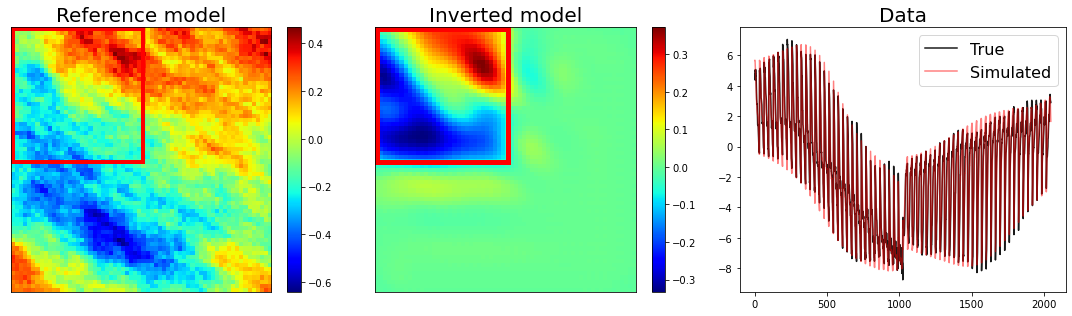

In [105]:
from matplotlib.patches import Rectangle
from PIL import Image
#forward simulation on the inverted model
m_sol8glo=np.reshape(m_sol8glo,(1,8,8,1))
m_sol64_8glo  = model_1.predict(m_sol8glo)[2]
m_sol64_8glo1=np.reshape(m_sol64_8glo,(64,64))
m_sol64_8glo1=m_sol64_8glo1[0:32,0:32]
m_sol64_8glo1=m_sol64_8glo1.flatten()
m_sol64_8glo1=np.squeeze(m_sol64_8glo1)
y_sim8glo = (m_sol64_8glo1.T@G_global).T


m_ref=np.reshape(m_ref,(64,64))
m_sol64_8glo=np.reshape(m_sol64_8glo,(64,64))
#compare model and data (i.e. reference case vs solution)
f = plt.figure(figsize=(15, 4.5))
plt.subplot(1, 3, 1)
plt.imshow(np.reshape(m_ref, [64, 64]), aspect='auto')
plt.gca().add_patch(Rectangle((0,0),32,32,linewidth=4,edgecolor='r',facecolor='none'))
plt.xticks([]), plt.yticks([])
plt.title("Reference model",fontsize = 20)
plt.colorbar(shrink=1)

plt.subplot(1,3, 2)
#m_sol64_8glo[abs(m_sol64_8glo) < 0.02] = np.nan # or use np.nan
plt.imshow(np.reshape(m_sol64_8glo, [64, 64]), aspect='auto')
#current_cmap = plt.cm.get_cmap()
#current_cmap.set_bad(color='white')
plt.gca().add_patch(Rectangle((0,0),32,32,linewidth=5,edgecolor='r',facecolor='none'))
plt.xticks([]), plt.yticks([])
plt.title("Inverted model",fontsize = 20)
plt.colorbar(shrink=1)

plt.subplot(1, 3, 3)
plt.plot(d_obs_global, ls='-', c='k', label='True', alpha=0.9)
plt.plot(y_sim8glo, c='r', label='Simulated', alpha=0.5)
plt.title("Data",fontsize = 20)
plt.legend(loc=1, prop={'size': 16})

plt.tight_layout()
plt.savefig('Results2_Spatial_Multiscale',dpi=500)

In [99]:
## Metric
model_metric_8glob=np.sqrt(np.mean(np.square(m_sol64_8glo[:32,:32]-m_ref[:32,:32])))
model_metric_8glob = "{:.4f}".format(model_metric_8glob)    
data_metric_8glob=np.sqrt(np.mean(np.square(d_obs_global-y_sim8glo)))
data_metric_8glob = "{:.4f}".format(data_metric_8glob)
print(m_sol64_8glo.shape)
print(m_ref.shape)
print(d_obs_global.shape)
print(y_sim8glo.shape)
print('model error 8glob RMSE:'+str(model_metric_8glob))
print('data  error 8glob RMSE:'+str(data_metric_8glob))

(64, 64)
(64, 64)
(2048,)
(2048,)
model error 8glob RMSE:0.0702
data  error 8glob RMSE:0.5837
